In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import sys
sys.path.append("lib")

import lib

import torch
torch.set_default_dtype(torch.float64)

from functorch import vmap
from torch.utils.data import DataLoader
import tqdm

/home/peiyi/mambaforge3/envs/rom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda")

In [3]:
coords_x, coords_y, _ = lib.utils.read_coords("2d_burger_data/time_step_0.csv")
coords = torch.stack((coords_x, coords_y), dim=1)

In [4]:
dt = 0.004
num_steps = 501
num_nodes = coords_x.shape[0]

datas = lib.utils.read_data(num_steps, num_nodes, '2d_burger_data/time_step_', 'vel_0')
datas.shape

torch.Size([501, 14641])

In [5]:
u_dot = lib.utils.u_dot(datas, dt)

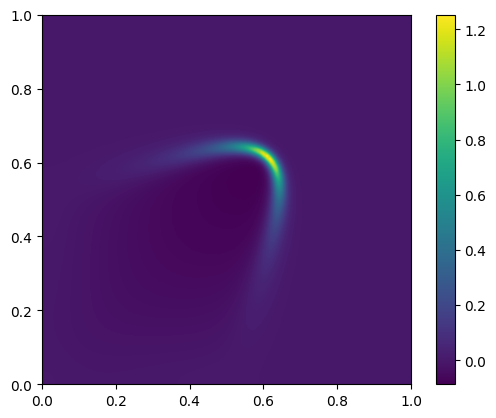

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = u_dot[455].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [7]:
datas = u_dot

In [8]:
N = datas.shape[1]
n = 20
mu = int(np.ceil(N/20))
neighbours = lib.utils.topk_neighbours(coords, mu)

In [9]:
batch_size = 20
train_data = DataLoader(datas, batch_size=batch_size, shuffle=True)

In [10]:
ed = lib.nrbs_n_1.EncoderDecoder(N=N, n=n, mu=mu, neighbours=neighbours, device=device)

In [11]:
vmap_bubble = vmap(ed.nrbs.bubble, in_dims=0)
vmap_vmap_bubble = vmap(vmap_bubble, in_dims=0)

In [12]:
encoded = ed.nrbs.encode(datas[:15].to(device))

In [14]:
decoded = ed.nrbs.decode(encoded)

In [15]:
decoded.shape

torch.Size([15, 14641])

In [12]:
node_idx = torch.linspace(0, N - 1, N, dtype=torch.long)

In [13]:
bubbles = vmap_vmap_bubble(torch.sigmoid(ed.nrbs.bandwidth_layer(encoded)))

In [16]:
bubbles.shape

torch.Size([15, 20, 733])

In [14]:
bubbles[:, 0, :].shape

torch.Size([15, 733])

In [17]:
basis = ed.nrbs.decoder[:, ed.nrbs.getNeighbours(node_idx)]
basis.shape

torch.Size([20, 14641, 733])

In [20]:
bubbles = bubbles.permute((1, 0, 2))

torch.Size([20, 15, 733])

In [23]:
bubbles.shape

torch.Size([20, 15, 733])

In [18]:
basis = basis.permute((0, 2, 1))

torch.Size([20, 733, 14641])

In [22]:
basis.shape

torch.Size([20, 733, 14641])

In [24]:
ans = torch.bmm(bubbles, basis)
ans.shape

torch.Size([20, 15, 14641])

In [16]:
ed.nrbs.decoder[0][ed.nrbs.getNeighbours(node_idx)].shape

torch.Size([14641, 733])

In [12]:
ed.train(train_data_loader=train_data, epochs=1)

100%|██████████| 25/25 [00:33<00:00,  1.34s/it]


Itr 0, loss = 40333.76090627243


In [13]:
ed.nrbs = torch.load('models/nrbs.pth')

In [14]:
approximates = ed(datas[499:501].to(device))
approximates.shape

torch.Size([1, 14641])

In [15]:
approximates[0]

tensor([0.0114, 0.0119, 0.0105,  ..., 0.0053, 0.0052, 0.0048], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [16]:
datas[489]

tensor([2.5750e-03, 2.4500e-03, 2.3000e-03,  ..., 6.4447e-30, 6.4447e-30,
        9.2545e-30])

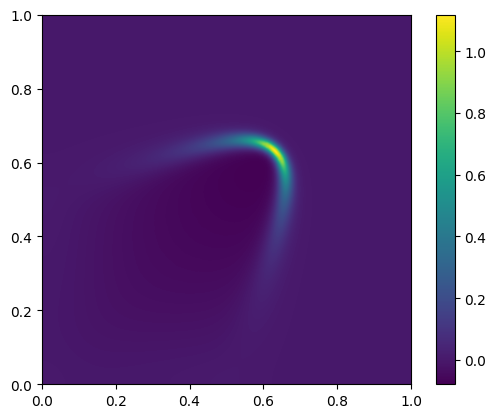

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = datas[499].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

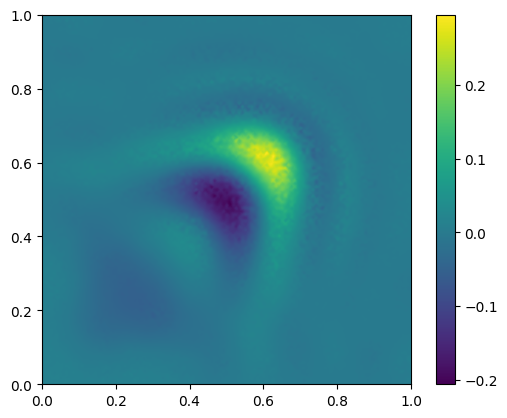

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = approximates[0].detach().cpu().tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

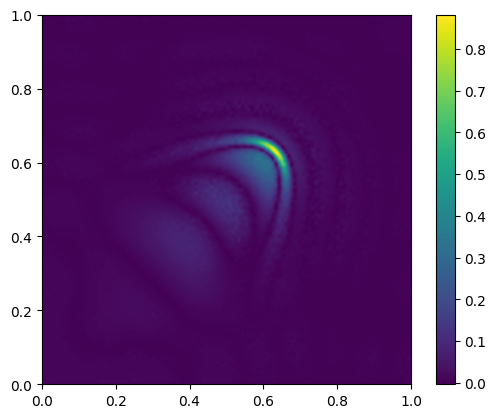

In [19]:
err = abs(datas[499] - approximates[0].detach().cpu())

# data coordinates and values
z = err.tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

In [21]:
# bws = ed.nrbs.bandwidth_layer(ed.nrbs.encode(datas[499:501].to(device)))
# bws = torch.sigmoid(bws)

In [22]:
bws = ed.nrbs.get_bandwidth(ed.nrbs.encode(datas[499:501].to(device)))

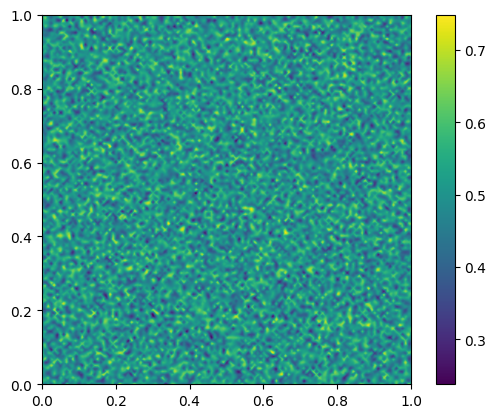

In [24]:
# data coordinates and values
z = bws[0].detach().cpu().tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()